# Ferry Irwandi's YouTube Comments Sentiment Analysis

Source: https://youtu.be/1qDL8bPuj_I?si=KjUyirzyV6JrWaYv

Dataset From: 10 August 2025

## Setup

### Imports

In [499]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
import ssl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import csv
import requests
from io import StringIO
from wordcloud import WordCloud
import os
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



### Dependencies

#### NLTK

In [484]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/ekajaya740/nltk_data...
[nltk_data]    |   Package 

True

#### Dictionary


In [485]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")


### Utility Functions

In [503]:
def separator():
    print('=' * 100)
    print()

def pie_chart_by_column(df, column):
    value_counts = df[column].value_counts()
    
    title = f'Distribution of {column}'
    
    plt.figure(figsize=(10, 6))

    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.legend(title=column, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.xlabel('Categories', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.gca().set_aspect('equal') 
    
    plt.title(title, fontsize=16, pad=20)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    return value_counts

def wordcloud_by_column(df, column):    
    text = ' '.join(df[column].astype(str).tolist())
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}', fontsize=16)
    plt.show()

def show_classification_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculates and prints the accuracy and classification report.
    """
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"--- Metrics for {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    print("-" * (30 + len(model_name)))

def plot_accuracy_comparison(train_accuracy, test_accuracy, model_name="Model"):
    """
    Creates a bar chart to compare training and test accuracy.
    """
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Training Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['#1f77b4', '#ff7f0e'])
    plt.ylabel('Accuracy Score')
    plt.title(f'{model_name} - Accuracy Comparison')
    plt.ylim(0, 1.05)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Model"):
    """
    Creates a heatmap for the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()


## Loading Dataset

### Open CSV

In [487]:
csv_location = "./dataset/youtube_comments_20250810_131638.csv"

df = pd.read_csv(csv_location)

total_nan = df.isnull().sum().sum()
print(f"Total NaN values: {total_nan}")

separator()

total_duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {total_duplicates}")

separator()


df.describe()

Total NaN values: 3

Total duplicate rows: 6



,likes,reply_count
count,13385.000000,13385.000000
mean,6.356294,0.360777
std,187.829162,9.557049
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,13707.000000,639.000000


### Cleaning Data

In [488]:
df_cleaned = df.copy()

df_cleaned = df_cleaned.drop_duplicates(subset=['id'])
df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned.reset_index(drop=True)

df_cleaned.describe()

,likes,reply_count
count,13376.000000,13376.000000
mean,5.983777,0.334629
std,182.942281,9.060924
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,13707.000000,639.000000


## Preprocessing 

### Utilities

In [489]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['OMP_NUM_THREADS'] = str(mp.cpu_count())

factory = StemmerFactory()
stemmer = factory.create_stemmer()

mention_pattern = re.compile(r'@[A-Za-z0-9]+')
hashtag_pattern = re.compile(r'#[A-Za-z0-9]+')
rt_pattern = re.compile(r'RT[\s]')
url_pattern = re.compile(r"http\S+")
number_pattern = re.compile(r'[0-9]+')
non_word_pattern = re.compile(r'[^\w\s]')

listStopwords = set(stopwords.words('indonesian'))
listStopwords.update(stopwords.words('english'))
listStopwords.update([
    'yang', 'yg', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'tidak', 
    'ada', 'saya', 'kamu', 'dia', 'mereka', 'kita', 'aku', 'anda',
    'bisa', 'akan', 'sudah', 'belum', 'pernah', 'selalu', 'sering',
    'juga', 'sangat', 'sekali', 'hanya', 'cuma', 'hanya', 'lagi',
    'saja', 'saja', 'masih', 'telah', 'sedang', 'sedang', 'sambil',
    'dengan', 'atau', 'tetapi', 'namun', 'karena', 'sebab', 'jadi',
    'oleh', 'pada', 'sejak', 'sampai', 'tentang', 'tentang', 'melalui',
    'antara', 'antaranya', 'beserta', 'beserta', 'selain', 'selain',
    'adalah', 'ialah', 'yaitu', 'yakni', 'bahwa', 'kalau', 'jika',
    'bila', 'apabila', 'asal', 'asalkan', 'selama', 'sementara',
    'sebelum', 'sesudah', 'setelah', 'biar', 'biarpun', 'supaya',
    'agar', 'guna', 'untuk', 'guna', 'guna', 'guna', 'guna', 'guna',
    'gue', 'gua', 'gw', 'elu', 'elo', 'lu', 'loe', 'lo', 'ane',
    'aq', 'ak', 'kamu', 'kalian', 'kowe', 'koe', 'sampean', 
    'panjenengan',
    'kak', 'bro', 'sis', 'om', 'mbak', 'mbk', 'mimin', 'min',
    'mod', 'mas', 'masbro', 'tante', 'mbah', 'pak', 'ayah',
    'bu', 'mama', 'papa', 'bang', 'dek',
    'iya', 'iy', 'yes', 'oke', 'ok', 'okr', 'okeh', 'sip', 'siap',
    'gas', 'gaspol', 'gaskan', 'mantap', 'mantul', 'mantaap',
    'gak', 'nggak', 'ga', 'ngga', 'gpp', 'gapapa', 'gppp', 'gapap',
    'enggak', 'engga', 'tdk', 'kgk', 'kaga', 'kagak', 'g',
    'makasih', 'makasi', 'mks', 'thanks', 'thx', 'thankyou',
    'please', 'pls', 'sorry', 'maaf', 'mianhae', 'sori',
    'wkwk', 'wkwkwk', 'wk', 'haha', 'hahaha', 'hihi', 'hehe', 'huehue', 'xixi',
    'video', 'videos', 'channel', 'subscribe', 'subscribers',
    'like', 'likes', 'comment', 'comments', 'view', 'views',
    'watch', 'time', 'thanks', 'thank', 'please', 'much',
    'really', 'very', 'well', 'good', 'great', 'nice',
    'youtube', 'youtuber', 'content', 'content creator',
    'upload', 'uploader', 'stream', 'streamer', 'live',
    'trending', 'trend', 'viral', 'share', 'shares', 'nya', 'ya', 'gk', 'pa', 'si', 'dll', 'dg', 'dgn', 'df', 'sy',
    'sih', 'krnnya', 'krnnya', 'krnnya', 'krnnya', 'krn','aja', 'jd', 'kali', 'tri', 'isi', 'ala', 'utk', 'udh', 'jg', 'dr', 'b', 'doang', 'kek', 'dah', 'te', 'bgt', 'banget', 'tuh', 'gin', 'bata', 'erti', 'pas', 'bener', 'dapet', 'te', 'ken', 'klo', 'kl', 'ki'])


slang_words = {
    'ku': 'saya',
    "gue": "saya",
    "gua": "saya", 
    "gw": "saya",
    "elu": "kamu",
    "elo": "kamu",
    "lu": "kamu",
    "loe": "kamu",
    "lo": "kamu",
    "ane": "saya",
    "aq": "saya",
    "ak": "saya",
    "aku": "saya",
    "kamu": "anda",
    "kita": "kami",
    "kitorang": "kami",
    "kami": "kami",
    "kalian": "anda",
    "kowe": "kamu",
    "koe": "kamu",
    "sampean": "anda",
    "panjenengan": "anda",
    "kak": "kakak",
    "kakak": "kakak",
    "bro": "saudara",
    "brot": "saudara",
    "sis": "saudari",
    "mbak": "saudari",
    "mbk": "saudari",
    "mimin": "admin",
    "min": "admin",
    "mod": "moderator",
    "mas": "saudara",
    "masbro": "saudara",
    "om": "saudara",
    "tante": "saudari",
    "mbah": "saudara",
    "bapak": "bapak",
    "pak": "bapak",
    "ayah": "bapak",
    "ibu": "ibu",
    "bu": "ibu",
    "mama": "ibu",
    "papa": "bapak",
    "abang": "saudara",
    "bang": "saudara",
    "adik": "adik",
    "dek": "adik",
    "iya": "ya",
    "iy": "ya",
    "yes": "ya",
    "oke": "baik",
    "ok": "baik",
    "okr": "baik",
    "okeh": "baik",
    "ramay": "ramai",
    "guruyg": "guru",
    'sdm': 'sumber daya manusia',
    "sip": "baik",
    "siap": "siap",
    'gurunya': 'guru',
    'kalo': 'kalau',
    'emang': 'memang',
    'pr': 'pekerjaan rumah',
    'sd': 'sekolah dasar',
    'smp': 'sekolah menengah pertama',
    'sma': 'sekolah menengah atas',
    'smk': 'sekolah menengah kejuruan',
    'skrg': 'sekarang',
    'kayak': 'seperti',
    'ortu': 'orang tua',
    'pake': 'pakai',
    'ngajar': 'mengajar',
    'atur': 'mengatur',
    'ngomong': 'berbicara',
    'ngomongin': 'membicarakan',
    'udah': 'sudah',
    'bntu': 'bantu',
    'org': 'orang',
    'liat': 'lihat',
    'moga': 'semoga',
    'gnt': 'ganti',
    'temen': 'teman',
    'lulu': 'lulus',
    'tri didik': 'pendidikan',
    'laku': 'lakukan',
    'uji nasional': 'ujian nasional',
    'un': 'ujian nasional',
    'tuju': 'tujuan',
    'tau': 'tahu',
    'jabat': 'jabatan',
    'paham': 'mengerti',
    'susah': 'sulit',
    'guru guru': 'guru',
    'anakanak': 'anak-anak',
    'anak anak': 'anak-anak',
    'tuju': 'tujuan',
    'moga': 'semoga',
    'goblok': 'bodoh',
    'butuh': 'perlu',
    'indo': 'indonesia',
    'tolol': 'bodoh',
    'bego': 'bodoh',
    'gimana': 'bagaimana',

    }


def process_text(text):
    text_clean = mention_pattern.sub('', text)
    text_clean = hashtag_pattern.sub('', text_clean)  
    text_clean = rt_pattern.sub('', text_clean)
    text_clean = url_pattern.sub('', text_clean)
    text_clean = number_pattern.sub('', text_clean)
    text_clean = non_word_pattern.sub('', text_clean)
    text_clean = text_clean.replace('\n', ' ')
    text_clean = text_clean.translate(str.maketrans('', '', string.punctuation))
    text_clean = text_clean.strip()
    
    text_casefolding = text_clean.lower()
    
    words = text_casefolding.split()
    words_fixed = [slang_words.get(word, word) for word in words]
    text_slangwords = ' '.join(words_fixed)
    
    text_stemming = stemmer.stem(text_slangwords)
    
    text_tokenizing = word_tokenize(text_stemming)
    
    text_filtering = [token for token in text_tokenizing if token not in listStopwords]
    
    text_final = ' '.join(text_filtering)
    
    return {
        'text_clean': text_clean,
        'text_casefolding': text_casefolding,
        'text_slangwords': text_slangwords,
        'text_stemming': text_stemming,
        'text_tokenizing': text_tokenizing,
        'text_filtering': text_filtering,
        'text_final': text_final
    }


In [490]:
def process_text_ultra_fast(text):
    """
    Ultra-optimized function for M1 Mac
    """
    # Early return for empty/None text
    if not text or pd.isna(text):
        return pd.Series({
            'text_clean': '',
            'text_casefolding': '',
            'text_slangwords': '',
            'text_stemming': '',
            'text_tokenizing': [],
            'text_filtering': [],
            'text_final': ''
        })
    
    # 1. Cleaning (vectorized regex operations)
    text_clean = text
    for pattern in [mention_pattern, hashtag_pattern, rt_pattern, url_pattern, 
                   number_pattern, non_word_pattern]:
        text_clean = pattern.sub('', text_clean)
    
    text_clean = text_clean.replace('\n', ' ')
    text_clean = text_clean.translate(str.maketrans('', '', string.punctuation))
    text_clean = text_clean.strip()
    
    # Early return for empty text after cleaning
    if not text_clean:
        return pd.Series({
            'text_clean': text_clean,
            'text_casefolding': '',
            'text_slangwords': '',
            'text_stemming': '',
            'text_tokenizing': [],
            'text_filtering': [],
            'text_final': ''
        })
    
    # 2. Case folding
    text_casefolding = text_clean.lower()
    
    # 3. Fix slang words (optimized with list comprehension)
    words = text_casefolding.split()
    words_fixed = [slang_words.get(word, word) for word in words]
    text_slangwords = ' '.join(words_fixed)
    
    # 4. Stemming
    text_stemming = stemmer.stem(text_slangwords)
    
    # 5. Tokenizing
    text_tokenizing = word_tokenize(text_stemming)
    
    # 6. Filtering stopwords (optimized with list comprehension)
    text_filtering = [token for token in text_tokenizing if token not in listStopwords and token.strip()]
    
    # 7. Final text
    text_final = ' '.join(text_filtering)
    
    return pd.Series({
        'text_clean': text_clean,
        'text_casefolding': text_casefolding,
        'text_slangwords': text_slangwords,
        'text_stemming': text_stemming,
        'text_tokenizing': text_tokenizing,
        'text_filtering': text_filtering,
        'text_final': text_final
    })

def process_chunk(chunk_data):
    """
    Process a chunk of data for multiprocessing
    """
    return chunk_data.apply(process_text_ultra_fast)

def m1_optimized_preprocessing(df, n_processes=None):
    """
    M1 Mac optimized preprocessing with multiprocessing
    """
    if n_processes is None:
        # M1 Mac has 8-10 cores, use most of them
        n_processes = min(mp.cpu_count() - 1, 8)
    
    print(f"Using {n_processes} processes on M1 Mac")
    print(f"Processing {len(df)} rows...")
    
    # Split dataframe into chunks
    chunk_size = max(1, len(df) // n_processes)
    chunks = [df['text'].iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    
    # Process chunks in parallel
    with ProcessPoolExecutor(max_workers=n_processes) as executor:
        results = list(tqdm(
            executor.map(process_chunk, chunks), 
            total=len(chunks),
            desc="Processing chunks"
        ))
    
    # Combine results
    final_results = pd.concat(results, ignore_index=True)
    
    return final_results

# Method 1: Ultra-fast single-threaded (recommended to try first)
def run_single_threaded(df):
    print("Running single-threaded ultra-optimized version...")
    tqdm.pandas(desc="Processing texts")
    return df['text'].progress_apply(process_text_ultra_fast)


preprocessing_results = run_single_threaded(df_cleaned)
df_cleaned = pd.concat([df_cleaned, preprocessing_results], axis=1)


# preprocessing_results = parallel_apply_joblib(df_cleaned['text'], process_text, n_cores=4)
# df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), preprocessing_results], axis=1)
# results = df_cleaned['text'].apply(process_text)

# Extract each step into separate columns
# df_cleaned['text_clean'] = results.apply(lambda x: x['text_clean'])
# df_cleaned['text_casefolding'] = results.apply(lambda x: x['text_casefolding'])
# df_cleaned['text_slangwords'] = results.apply(lambda x: x['text_slangwords'])
# df_cleaned['text_stemming'] = results.apply(lambda x: x['text_stemming'])
# df_cleaned['text_tokenizing'] = results.apply(lambda x: x['text_tokenizing'])
# df_cleaned['text_filtering'] = results.apply(lambda x: x['text_filtering'])
# df_cleaned['text_final'] = results.apply(lambda x: x['text_final'])

df_cleaned.head()


Running single-threaded ultra-optimized version...


Processing texts: 100%|██████████| 13376/13376 [22:42<00:00,  9.82it/s] 


,id,author,date,text,likes,reply_count,is_reply,text_clean,text_casefolding,text_slangwords,text_stemming,text_tokenizing,text_filtering,text_final
0,UgyDaegI4nlyU3VPtwN4AaABAg,@ferryirwandi,2024-10-10T09:02:59Z,"hallo warga sipil sekalian, selamat menonton",4961,353,False,hallo warga sipil sekalian selamat menonton,hallo warga sipil sekalian selamat menonton,hallo warga sipil sekalian selamat menonton,hallo warga sipil sekali selamat tonton,"[hallo, warga, sipil, sekali, selamat, tonton]","[hallo, warga, sipil, selamat, tonton]",hallo warga sipil selamat tonton
1,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXVwN07dK,@KaebyDS,2024-10-10T09:03:28Z,Selamat makan,42,0,True,Selamat makan,selamat makan,selamat makan,selamat makan,"[selamat, makan]","[selamat, makan]",selamat makan
2,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXXECSUqA,@raditt.27579,2024-10-10T09:03:38Z,okr,16,0,True,okr,okr,baik,baik,[baik],[],
3,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXdPOTaZ3,@hirumayoichi2625,2024-10-10T09:04:37Z,Bagaimana pendapat Bang Ferry tentang kegiatan...,13,0,True,Bagaimana pendapat Bang Ferry tentang kegiatan...,bagaimana pendapat bang ferry tentang kegiatan...,bagaimana pendapat saudara ferry tentang kegia...,bagaimana dapat saudara ferry tentang giat okt...,"[bagaimana, dapat, saudara, ferry, tentang, gi...","[saudara, ferry, giat, oktober]",saudara ferry giat oktober
4,UgyDaegI4nlyU3VPtwN4AaABAg.A9PXST3-y1GA9PXzT80NlM,@muhammadprajawanto8749,2024-10-10T09:07:38Z,Akan ada the people power,6,0,True,Akan ada the people power,akan ada the people power,akan ada the people power,akan ada the people power,"[akan, ada, the, people, power]","[people, power]",people power


### Polarity Analysis

#### Utilities

In [491]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
        
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

#### Analysis

negative    6938
positive    6438
Name: polarity, dtype: int64


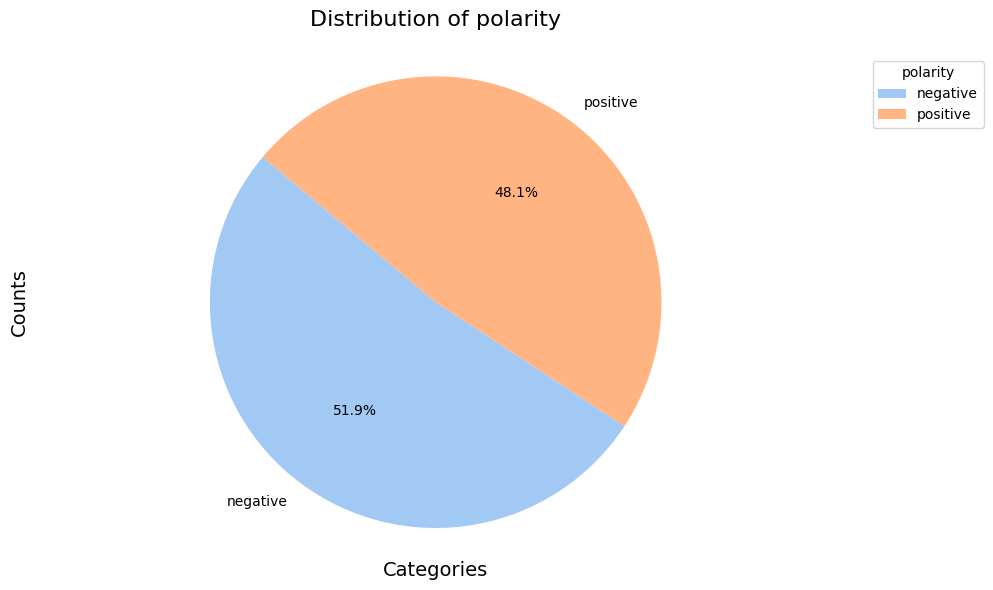

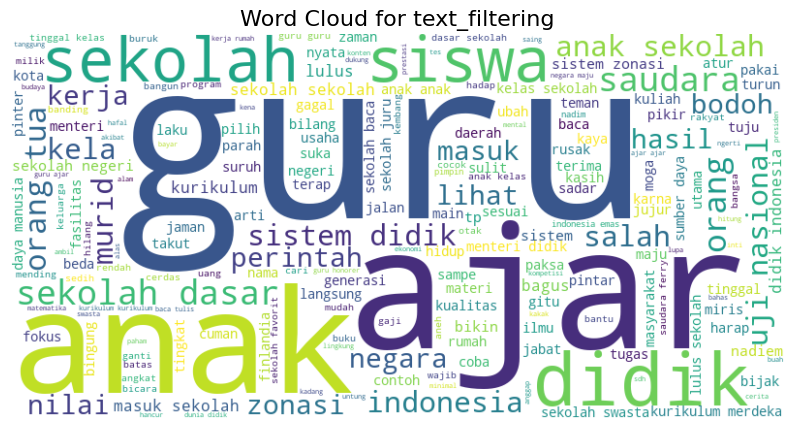

In [492]:
results = df_cleaned['text_filtering'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_cleaned['polarity_score'] = results[0]
df_cleaned['polarity'] = results[1]
print(df_cleaned['polarity'].value_counts())

pie_chart_by_column(df_cleaned, 'polarity')
separator()
wordcloud_by_column(df_cleaned, 'text_filtering')
separator()


### Feature Extraction

#### TF-IDF

In [535]:
X = df_cleaned['text_final']
y = df_cleaned['polarity']

tfidf = TfidfVectorizer(max_features=400, min_df=17, max_df=0.8, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

df_features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


--- Metrics for Naive Bayes (Train) ---
Accuracy: 0.7248

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.64      0.71      5582
    positive       0.68      0.82      0.74      5118

    accuracy                           0.72     10700
   macro avg       0.73      0.73      0.72     10700
weighted avg       0.74      0.72      0.72     10700

-------------------------------------------------
--- Metrics for Naive Bayes (Test) ---
Accuracy: 0.7257

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.65      0.71      1356
    positive       0.69      0.81      0.74      1320

    accuracy                           0.73      2676
   macro avg       0.73      0.73      0.72      2676
weighted avg       0.73      0.73      0.72      2676

------------------------------------------------


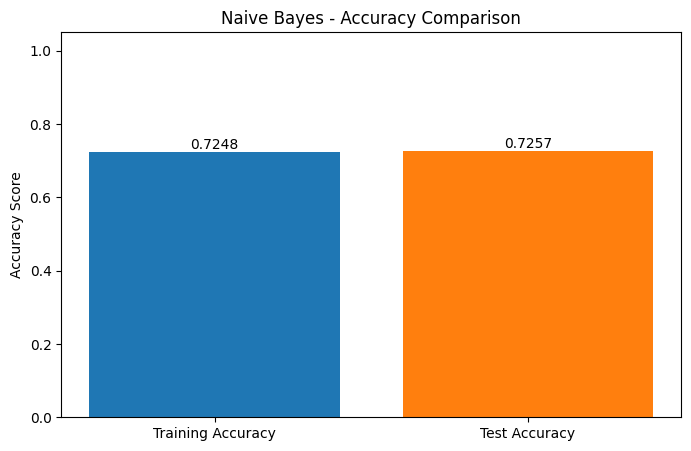

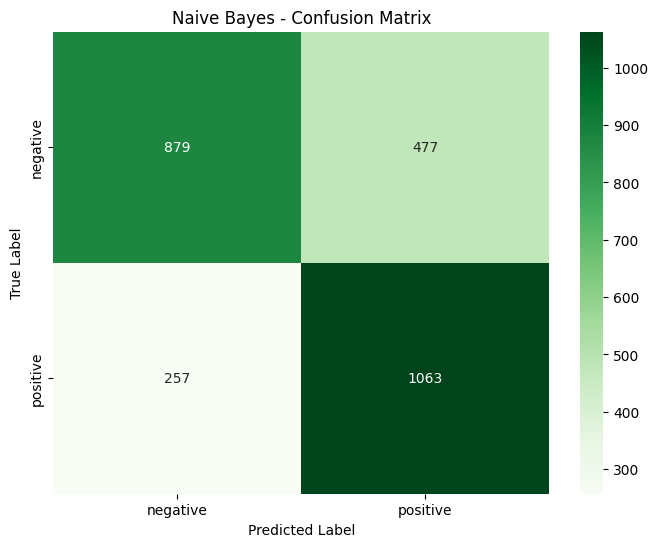

In [536]:
naive_bayes = BernoulliNB()

naive_bayes.fit(X_tfidf_train.toarray(), y_tfidf_train)

y_pred = naive_bayes.predict(X_tfidf_test.toarray())

naive_bayes.fit(X_tfidf_train.toarray(), y_tfidf_train)

y_pred_train_nb = naive_bayes.predict(X_tfidf_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_tfidf_test.toarray())
 

accuracy_train_nb = accuracy_score(y_pred_train_nb, y_tfidf_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_tfidf_test)

show_classification_metrics(y_tfidf_train, y_pred_train_nb, model_name="Naive Bayes (Train)")
show_classification_metrics(y_tfidf_test, y_pred_test_nb, model_name="Naive Bayes (Test)")
plot_accuracy_comparison(accuracy_train_nb, accuracy_test_nb, model_name="Naive Bayes")
plot_confusion_matrix(y_tfidf_test, y_pred_test_nb, class_names=naive_bayes.classes_, model_name="Naive Bayes")

